# Many model comparison

This notebook piggybacks off off the [cartesian infrastructure](https://github.com/matsengrp/torchdms-experiments/tree/master/tdmsex/scripts) for training `torchdms` models. It collects all the models into a descriptive dataframe, and then predicts on the octet data from the victora lab. Here, we are predicting on higher-order, higher affinity mutants to find possible causes for "the wall" (i.e. models _stochastically_ seem to have a ceiling on predicting phenotypes - and it depends mostly on the seed). While we're targetting the octet dataset, this same infrastructure could be used for hyper-parameter tuning and testing for model consistany in other contexts, as well.

In [239]:
import pickle
import json
import os
import sys
from functools import reduce
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import torch
from Bio.Seq import Seq
from Bio import SeqIO
import binarymap
import glob
import gctree

from plotnine import *
import matplotlib.pyplot as plt
%matplotlib inline

## Which experiments to compare?

In [240]:
data_dir = "../nextflow/data/torchdms/raw-dms"
prepped_dir = "../nextflow/data/torchdms/prepped-dms"
pos_csv_path = "https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv"
octet_data_path = f"{prepped_dir}/calibrated-octet-data.csv"

exp_rhino_path = "/home/jgallowa/Projects/torchdms/torchdms-experiments/experiments"
models_dir = "calibrated_octet_models"
exps = [
    "2022-05-05-calibrated-octet"
]

## `rsync` all .model files

In [241]:
for exp in exps:
    ! rsync -v -a -m --include='**/*.model' --include='*/' --include='**/*.csv' --exclude='*' --ignore-existing \
        jgallowa@rhino.fhcrc.org:{exp_rhino_path}/{exp}/_output {models_dir}

receiving file list ... done

sent 65 bytes  received 27,784 bytes  2,931.47 bytes/sec
total size is 11,121,432  speedup is 399.35


In [242]:
! tree -L 3 {models_dir}/

calibrated_octet_models/
└── _output
    ├── loss_fn@huber
    │   ├── model_string@FullyConnected;[2_6];[None_'relu']
    │   └── model_string@Linear
    ├── loss_fn@l1
    │   ├── model_string@FullyConnected;[2_6];[None_'relu']
    │   └── model_string@Linear
    └── loss_fn@mse
        ├── model_string@FullyConnected;[2_6];[None_'relu']
        └── model_string@Linear

10 directories, 0 files


## Collect all models into a descriptive df

In [243]:
# collect the models
models = defaultdict(list)
for i, path in enumerate(glob.glob(f'{models_dir}/**/*.model', recursive=True)):
    dir_struct = path.split("/")
    models["model_name"].append(dir_struct[-1])
    models["model"].append(torch.load(path, map_location="cpu"))
    for des in dir_struct[2:-1]:
        param, value = des.split("@")
        models[param].append(value)

model_df = pd.DataFrame(models)
model_df = model_df.assign(model_id=range(len(model_df)))
model_df

,model_name,model,loss_fn,model_string,seed,model_id
0,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,12,0
1,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,2,1
2,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,20,2
3,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,5,3
4,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,4,4
...,...,...,...,...,...,...
175,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],26,175
176,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],21,176
177,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],24,177
178,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],27,178


In [244]:
model_df.model_name.value_counts()

CGG-octet-cali-sceil-3.model    180
Name: model_name, dtype: int64

## Collect position dataframe

In [245]:
pos_df = pd.read_csv("https://raw.githubusercontent.com/jbloomlab/Ab-CGGnaive_DMS/main/data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


## Collect final variant scores

In [246]:
final_multi_variant_scores = pd.read_csv(f"{prepped_dir}/final-multi-variant-scores.csv")

In [247]:
final_multi_variant_scores

,aa_substitutions,aa_substitutions_IMGT,n_aa_substitutions,aa_sequence,delta_bind,delta_stab,delta_poly,bind,stab,poly,library,unseen_mutations,split_set
0,A91T T132L,A100(H)T T5(L)L,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.120389,-1.225703,1.614845,9.321501,9.220537,8.631975,dms,False,test
1,A96T D98S,A105(H)T D107(H)S,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-0.583298,0.062470,0.589685,9.858592,10.508710,7.606815,dms,False,test
2,C150W E208C,C23(L)W E97(L)C,2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,-1.318972,-2.448595,1.309087,9.122918,7.997645,8.326217,dms,False,test
3,C22H S134R G143P,C23(H)H S7(L)R G16(L)P,3,EVQLQESGPSLVKPSQTLSLTHSVTGDSITSGYWNWIRKFPGNKLE...,NaN,-3.872965,1.305743,NaN,6.573275,8.322873,dms,False,test
4,C22N S28T I233T,C23(H)N S29(H)T I126(L)T,3,EVQLQESGPSLVKPSQTLSLTNSVTGDTITSGYWNWIRKFPGNKLE...,-1.070922,-1.750284,0.657205,9.370968,8.695956,7.674335,dms,False,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16715,A161G Y163F A173S N219Y,A40(L)G Y42(L)F A52(L)S N108(L)Y,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.562305,NaN,NaN,9.492144,NaN,NaN,octet,NaN,train
16716,A161G Y163F A173S Q216H N219Y,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.690806,NaN,NaN,9.583359,NaN,NaN,octet,NaN,train
16717,A161G Y163F A173S N219S,A40(L)G Y42(L)F A52(L)S N108(L)S,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.423506,NaN,NaN,9.393619,NaN,NaN,octet,NaN,train
16718,A161G Y163F A173S Q216H N219S,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)S,3,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,2.428066,NaN,NaN,9.396856,NaN,NaN,octet,NaN,train


## Parse octet data

In [249]:
octet_df = final_multi_variant_scores.query("library == 'octet'").reset_index().copy()
id_vars = ["aa_sequence", "aa_substitutions_IMGT", "aa_substitutions", "delta_bind", "split_set"]
octet_df = octet_df[id_vars]
octet_df

,aa_sequence,aa_substitutions_IMGT,aa_substitutions,delta_bind,split_set
0,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRKFPGNRLE...,D28(H)A K49(H)R S64(H)G A40(L)G Y42(L)F A52(L)...,D27A K44R S56G A161G Y163F A173S Q216H N219Y,3.572199,test
1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,A40(L)G,A161G,0.989529,train
2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,A40(L)V,A161V,-0.571533,train
3,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRKFPGNKLE...,D28(H)A,D27A,1.050609,train
4,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRRFPGNKLE...,K44(H)R,K39R,-0.030445,train
5,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNRLE...,K49(H)R,K44R,-0.010932,train
6,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,Y42(L)F,Y163F,-0.041322,train
7,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,A52(L)S,A173S,0.747789,train
8,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,Y55(L)F,Y176F,0.237139,train
9,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,N108(L)S,N219S,0.216255,train


## Predict octet data points with every model

In [250]:
# now add all model predictions
# just bind for now
model_pred = {}
for idx, row in model_df.iterrows():
    model_pred[row.model_id] = [
        row.model(row.model.seq_to_binary("".join(aa_seq))).detach().numpy()[0]
        for aa_seq in octet_df.aa_sequence.values
    ]
model_pred_df = pd.DataFrame(model_pred).astype(float)
assert len(model_pred_df) == len(octet_df)
model_pred_df

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,3.517479,3.513185,3.503452,3.538495,3.496606,3.528670,3.505955,3.504232,3.480615,3.505781,...,3.390306,3.297207,3.299635,3.145709,0.000000,3.321274,3.344878,3.035782,3.561685,3.379340
1,0.701305,0.666223,0.723876,0.669666,0.701276,0.731555,0.751241,0.733809,0.728899,0.632632,...,0.859620,0.600749,0.692124,1.330904,0.000000,0.543948,0.732103,0.880460,1.766339,1.063224
2,-0.940693,-0.981200,-0.918767,-0.974390,-0.945475,-0.916031,-0.891115,-0.910869,-0.909821,-1.016352,...,-0.885487,-0.470230,-0.366344,-0.361456,-0.519706,-0.694439,-0.555262,-0.437264,-0.862639,-0.828471
3,0.380805,0.349643,0.405670,0.340747,0.384668,0.408373,0.433910,0.415803,0.418729,0.310568,...,0.725349,0.446576,0.409764,0.292369,0.000000,0.447498,0.569369,0.271389,0.220668,0.679726
4,-0.333200,-0.374436,-0.304745,-0.374459,-0.330002,-0.301092,-0.269532,-0.289603,-0.288053,-0.404339,...,0.156586,0.233956,0.250435,0.246071,0.000000,-0.004200,0.196621,0.233588,0.022532,0.072920
5,-0.222916,-0.257659,-0.198551,-0.255206,-0.222814,-0.194117,-0.170678,-0.189983,-0.189092,-0.287697,...,0.148525,0.083704,0.135175,-0.001444,-0.036054,0.120100,0.115117,-0.028363,0.054359,-0.028590
6,0.040038,0.021745,0.052371,0.034987,0.028851,0.067012,0.072869,0.057933,0.050637,0.003135,...,0.123052,0.550297,0.529328,0.663810,-0.002216,0.411911,0.530528,0.620914,0.440095,0.129578
7,0.110931,0.072806,0.138337,0.075844,0.113739,0.140690,0.170951,0.149769,0.154022,0.043500,...,0.395583,0.385319,0.305660,0.150418,-0.010428,0.315636,0.335267,0.098043,0.416496,0.419324
8,-0.007398,-0.017705,-0.002290,-0.000336,-0.022310,0.013399,0.009297,0.001682,-0.016850,-0.028377,...,0.155302,0.335685,0.202517,0.006078,-0.003631,0.152296,0.323506,-0.066045,-0.113507,0.117733
9,0.336331,0.307047,0.354979,0.310441,0.335132,0.362092,0.378072,0.363541,0.359326,0.280548,...,0.610888,0.539749,0.437360,0.232622,0.000000,0.562705,0.600834,0.231535,-0.042025,0.505784


In [251]:
octet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   aa_sequence            27 non-null     object 
 1   aa_substitutions_IMGT  27 non-null     object 
 2   aa_substitutions       27 non-null     object 
 3   delta_bind             27 non-null     float64
 4   split_set              27 non-null     object 
dtypes: float64(1), object(4)
memory usage: 1.2+ KB


## Make it ggplot-able (i.e. tall)

In [252]:
octet_df_tall = (
octet_df.join(model_pred_df)
    .melt(id_vars=id_vars, var_name="model_id", value_name="pred_delta_bind")
    .merge(model_df, on="model_id", how="outer")
)
octet_df_tall = octet_df_tall.assign(
    n_aa_substitutions = [
        len(aa_subs.split()) 
        if aa_subs == aa_subs else 0
        for aa_subs in octet_df_tall.aa_substitutions.values
    ]
)
octet_df_tall

,aa_sequence,aa_substitutions_IMGT,aa_substitutions,delta_bind,split_set,model_id,pred_delta_bind,model_name,model,loss_fn,model_string,seed,n_aa_substitutions
0,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRKFPGNRLE...,D28(H)A K49(H)R S64(H)G A40(L)G Y42(L)F A52(L)...,D27A K44R S56G A161G Y163F A173S Q216H N219Y,3.572199,test,0,3.517479,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,12,8
1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,A40(L)G,A161G,0.989529,train,0,0.701305,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,12,1
2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,A40(L)V,A161V,-0.571533,train,0,-0.940693,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,12,1
3,EVQLQESGPSLVKPSQTLSLTCSVTGASITSGYWNWIRKFPGNKLE...,D28(H)A,D27A,1.050609,train,0,0.380805,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,12,1
4,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRRFPGNKLE...,K44(H)R,K39R,-0.030445,train,0,-0.333200,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4855,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,A40(L)G Y42(L)F A52(L)S N108(L)Y,A161G Y163F A173S N219Y,2.562305,train,179,2.532487,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],15,4
4856,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)Y,A161G Y163F A173S Q216H N219Y,2.690806,train,179,2.617304,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],15,5
4857,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,A40(L)G Y42(L)F A52(L)S N108(L)S,A161G Y163F A173S N219S,2.423506,train,179,2.448408,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],15,4
4858,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,A40(L)G Y42(L)F A52(L)S Q105(L)H N108(L)S,A161G Y163F A173S Q216H N219S,2.428066,train,179,2.423174,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],15,5


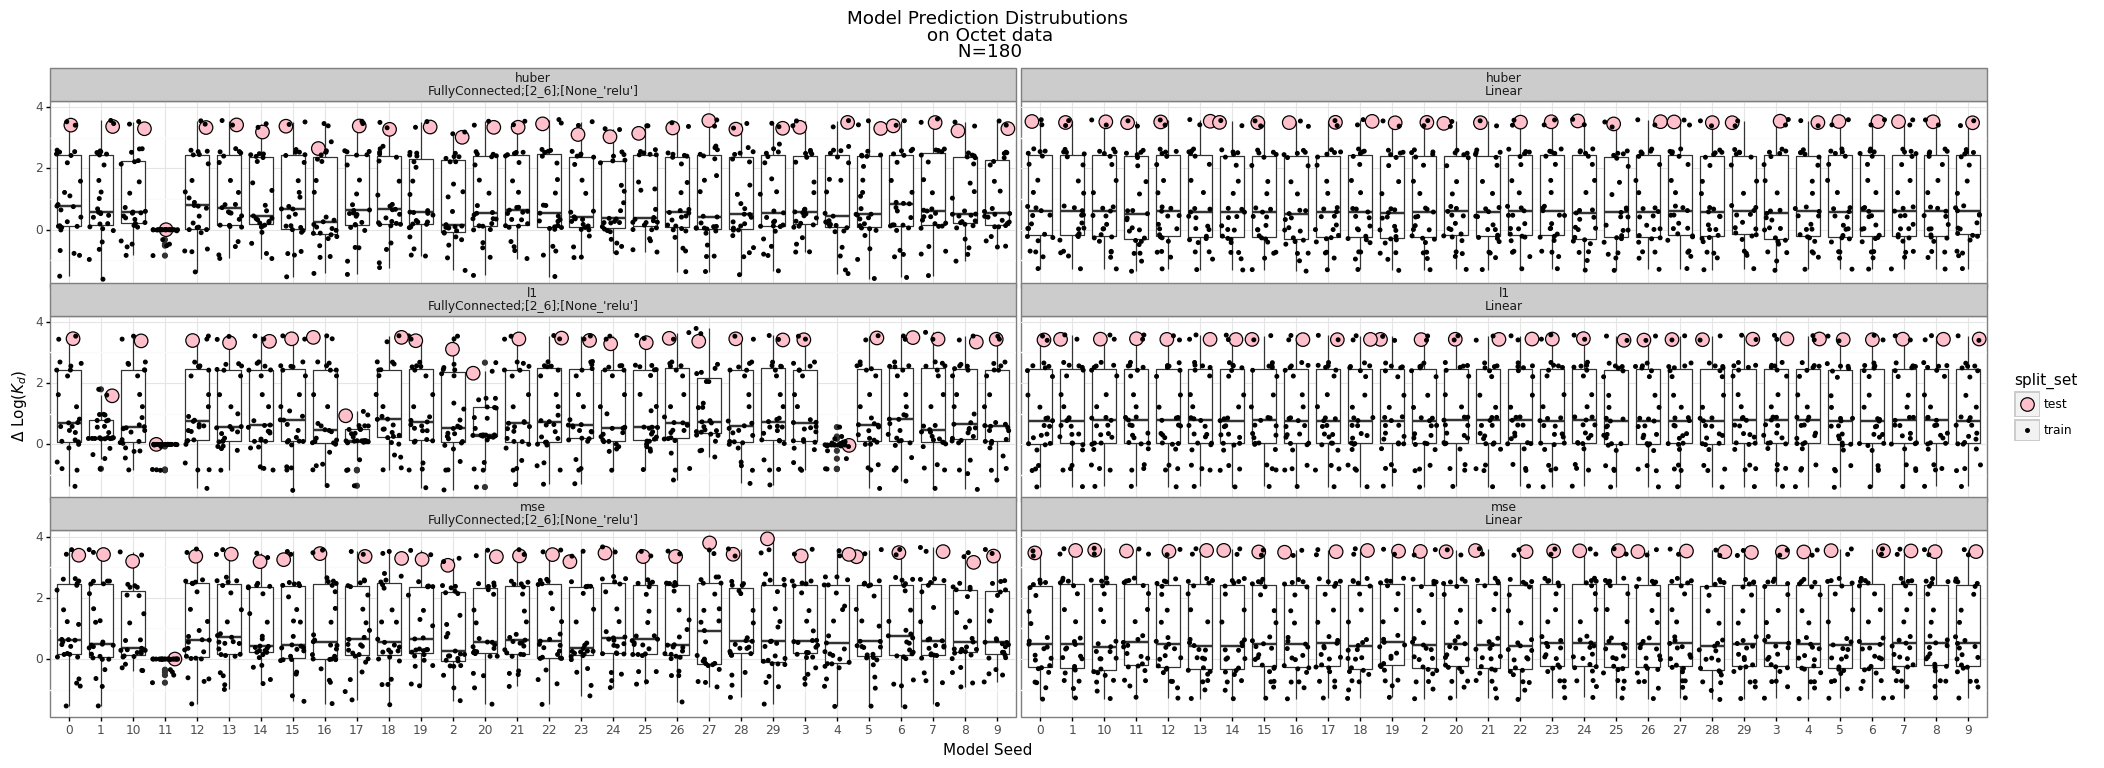

In [254]:
g = (
    ggplot(octet_df_tall)

    + geom_boxplot(
        aes(
            group="factor(model_id)",
            x="seed", 
            y="pred_delta_bind",
        ),
        show_legend=False
    )
    + geom_jitter(
        aes(
            group="factor(model_id)",
            x="seed", 
            y="pred_delta_bind",
#             fill="factor(n_aa_substitutions)",
            fill="split_set",
            size="split_set"
        ),
        show_legend=True
    )
    + facet_wrap(
        "~ loss_fn + model_string",
        ncol=2,
        scales = 'free_x'
    )
    + theme_bw()
    + theme(
        figure_size = (25, 8),
        subplots_adjust = {
            "hspace": 0.15,
            "wspace": 0.005
        },
    )
    + labs(
        title=f"Model Prediction Distrubutions\n on Octet data\n N={len(model_df)}",
        x = "Model Seed",
        y = "$\Delta$ Log($K_{d}$)"
    )
    + scale_fill_manual(
        {
            "test" : "pink",
            "train" : "black"
        }
    )
    + scale_size_manual (
        {
            "test" : 5,
            "train" : 1
        }
    )
)
_ = g.draw()

In [255]:
from datetime import date

In [256]:
g.save(f"boxplot-seed-replicate-octet-predictions.pdf")

## Held out test data (predicting from raw)

In [258]:
held_out_df = final_multi_variant_scores.query("split_set == 'test'").reset_index().copy()
id_vars = ["aa_sequence", "aa_substitutions_IMGT", "aa_substitutions", "delta_bind", "split_set"]
held_out_df = held_out_df[id_vars]
held_out_df

,aa_sequence,aa_substitutions_IMGT,aa_substitutions,delta_bind,split_set
0,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,A100(H)T T5(L)L,A91T T132L,-1.120389,test
1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,A105(H)T D107(H)S,A96T D98S,-0.583298,test
2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,C23(L)W E97(L)C,C150W E208C,-1.318972,test
3,EVQLQESGPSLVKPSQTLSLTHSVTGDSITSGYWNWIRKFPGNKLE...,C23(H)H S7(L)R G16(L)P,C22H S134R G143P,NaN,test
4,EVQLQESGPSLVKPSQTLSLTNSVTGDTITSGYWNWIRKFPGNKLE...,C23(H)N S29(H)T I126(L)T,C22N S28T I233T,-1.070922,test
...,...,...,...,...,...
95,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGSWNWIRKFPGNKLE...,Y38(H)S Q90(H)K N28(L)G,Y33S Q81K N155G,-4.059937,test
96,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,Y67(H)C P50(L)F,Y59C P171F,0.086404,test
97,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,Y87(H)S K24(L)R,Y78S K151R,-2.735464,test
98,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,Y103(H)C S26(L)C,Y94C S153C,-0.790973,test


In [259]:
model_pred = {}
for idx, row in model_df.iterrows():
    model_pred[row.model_id] = [
        row.model(row.model.seq_to_binary("".join(aa_seq))).detach().numpy()[0]
        for aa_seq in held_out_df.aa_sequence.values
    ]
model_pred_df = pd.DataFrame(model_pred).astype(float)
assert len(model_pred_df) == len(held_out_df)
model_pred_df

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,-0.986243,-1.003134,-0.984839,-0.978433,-1.001550,-0.970068,-0.974866,-0.973439,-1.004711,-1.020470,...,-1.136222,-1.112328,-0.944066,-0.926110,-1.209049,-0.969582,-1.241693,-0.935280,-0.855518,-1.114909
1,-3.070870,-3.012281,-3.171957,-2.925410,-3.158632,-3.112171,-3.233450,-3.185962,-3.281497,-2.953698,...,-3.660540,-1.321895,-3.076338,-0.715765,-2.223293,-3.744181,-1.521559,-0.751360,-3.576358,-3.875803
2,-0.644361,-0.634111,-0.661252,-0.605674,-0.669970,-0.629540,-0.659701,-0.650857,-0.695687,-0.631151,...,-0.552594,-1.341064,-0.913321,-1.126057,-0.792659,-0.477912,-1.650749,-1.111856,-0.656614,-0.368694
3,-0.473033,-0.481987,-0.515329,-0.444993,-0.503516,-0.473406,-0.509880,-0.496043,-0.561466,-0.461543,...,-0.691963,-1.045443,-0.616040,-0.977659,-0.728638,-0.397122,-1.103787,-1.046256,-1.099946,-0.585072
4,-0.036065,-0.012686,-0.065204,0.047035,-0.074044,-0.032430,-0.091453,-0.069457,-0.126579,0.014128,...,-0.667677,-1.847471,-1.125402,-1.426604,-1.360031,-0.544039,-2.146106,-1.499253,-1.102277,-0.670157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-2.589070,-2.495977,-2.722379,-2.354566,-2.699320,-2.636861,-2.815872,-2.723199,-2.864827,-2.382228,...,-3.128517,-0.685000,-2.850648,-0.643114,-0.561032,-3.060732,-0.604444,-0.749569,-3.135755,-3.144826
96,-0.068556,-0.080948,-0.069005,-0.066300,-0.082424,-0.050372,-0.061026,-0.067357,-0.087347,-0.101540,...,-0.034677,-0.043334,-0.009455,-0.361712,-0.098156,0.085629,-0.006683,-0.386715,-0.363385,-0.058649
97,-2.079216,-2.068517,-2.109425,-2.015453,-2.113510,-2.062411,-2.125944,-2.123187,-2.168592,-2.022311,...,-2.371550,-0.960074,-2.440610,-0.556777,-1.514376,-2.432325,-1.096717,-0.625959,-2.089266,-2.417704
98,0.183514,0.179125,0.173168,0.202943,0.166777,0.200825,0.182609,0.183490,0.150318,0.167186,...,0.015965,-0.377240,-0.173272,-0.512000,-0.277651,-0.156812,-0.325296,-0.577666,-0.431474,-0.003096


In [260]:
held_out_df_tall = (
held_out_df.join(model_pred_df)
    .melt(id_vars=id_vars, var_name="model_id", value_name="pred_delta_bind")
    .merge(model_df, on="model_id", how="outer")
)
held_out_df_tall = held_out_df_tall.assign(
    n_aa_substitutions = [
        len(aa_subs.split()) 
        if aa_subs == aa_subs else 0
        for aa_subs in held_out_df_tall.aa_substitutions.values
    ]
)
held_out_df_tall

,aa_sequence,aa_substitutions_IMGT,aa_substitutions,delta_bind,split_set,model_id,pred_delta_bind,model_name,model,loss_fn,model_string,seed,n_aa_substitutions
0,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,A100(H)T T5(L)L,A91T T132L,-1.120389,test,0,-0.986243,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,12,2
1,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,A105(H)T D107(H)S,A96T D98S,-0.583298,test,0,-3.070870,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,12,2
2,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,C23(L)W E97(L)C,C150W E208C,-1.318972,test,0,-0.644361,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,12,2
3,EVQLQESGPSLVKPSQTLSLTHSVTGDSITSGYWNWIRKFPGNKLE...,C23(H)H S7(L)R G16(L)P,C22H S134R G143P,NaN,test,0,-0.473033,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,12,3
4,EVQLQESGPSLVKPSQTLSLTNSVTGDTITSGYWNWIRKFPGNKLE...,C23(H)N S29(H)T I126(L)T,C22N S28T I233T,-1.070922,test,0,-0.036065,CGG-octet-cali-sceil-3.model,Linear(\n (latent_layer): Linear(in_features=...,mse,Linear,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGSWNWIRKFPGNKLE...,Y38(H)S Q90(H)K N28(L)G,Y33S Q81K N155G,-4.059937,test,179,-3.144826,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],15,3
17996,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,Y67(H)C P50(L)F,Y59C P171F,0.086404,test,179,-0.058649,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],15,2
17997,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,Y87(H)S K24(L)R,Y78S K151R,-2.735464,test,179,-2.417704,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],15,2
17998,EVQLQESGPSLVKPSQTLSLTCSVTGDSITSGYWNWIRKFPGNKLE...,Y103(H)C S26(L)C,Y94C S153C,-0.790973,test,179,-0.003096,CGG-octet-cali-sceil-3.model,FullyConnected(\n (latent_layer): Linear(in_f...,huber,FullyConnected;[2_6];[None_'relu'],15,2


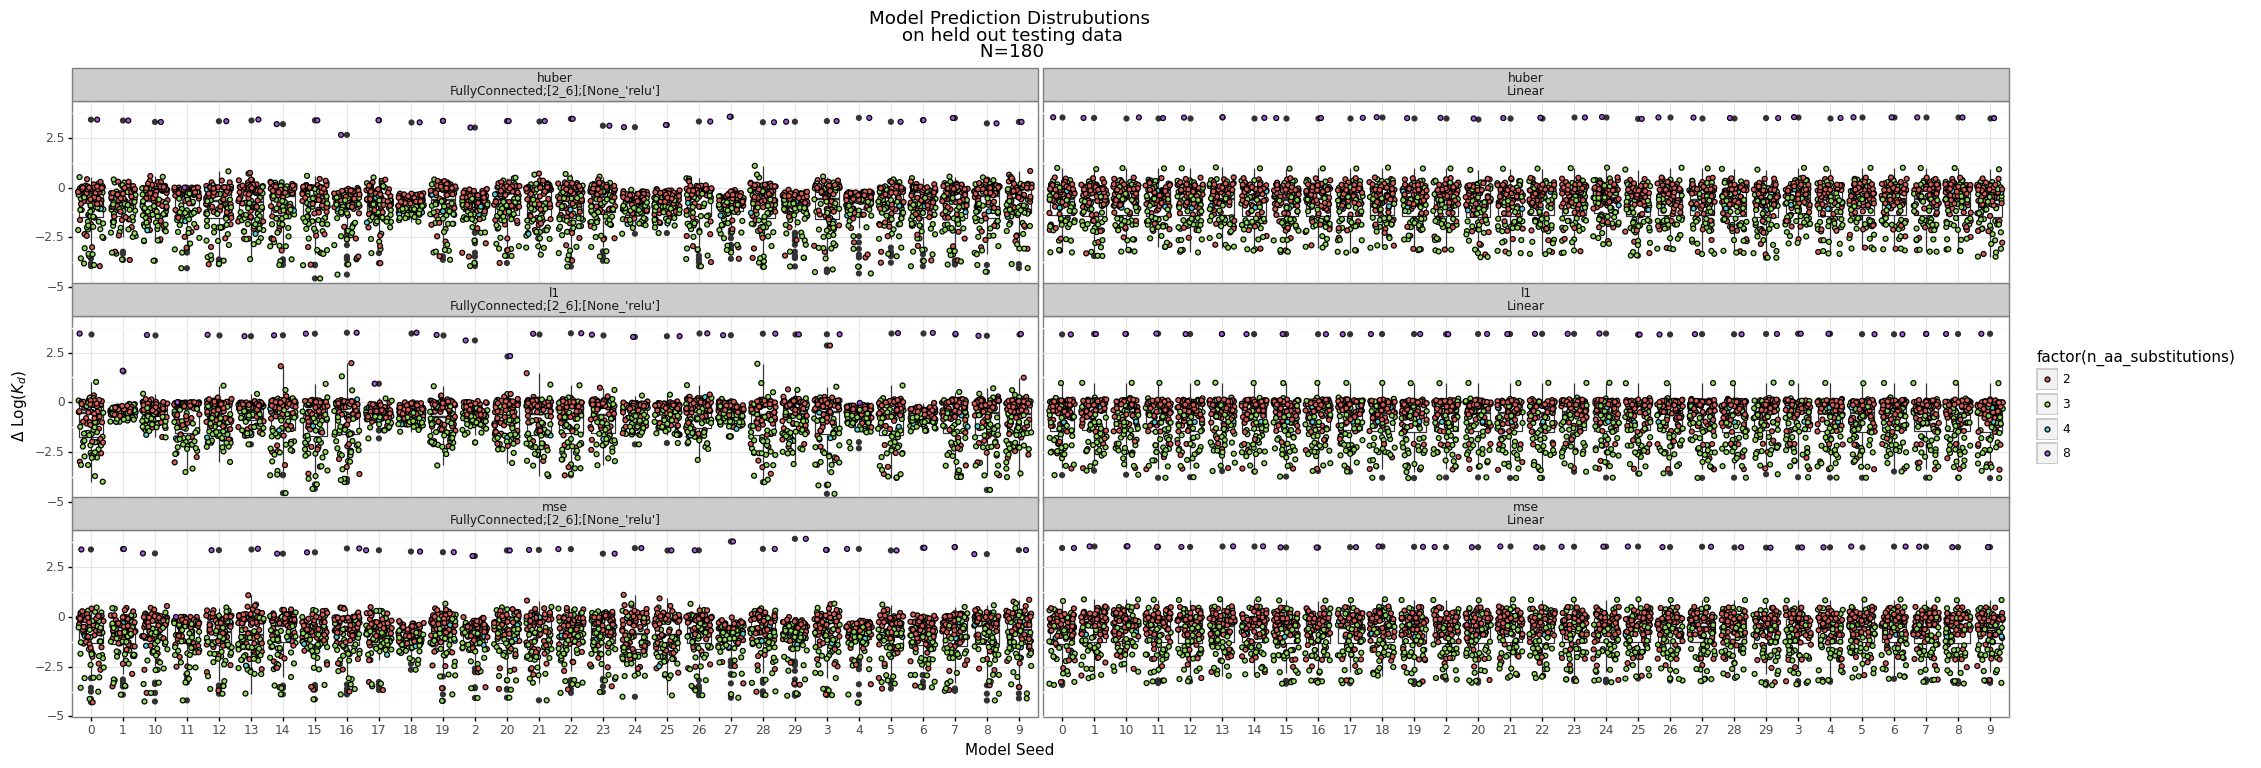

In [261]:
g = (
    ggplot(held_out_df_tall)

    + geom_boxplot(
        aes(
            group="factor(model_id)",
            x="seed", 
            y="pred_delta_bind",
        ),
        show_legend=False
    )
    + geom_jitter(
        aes(
            group="factor(model_id)",
            x="seed", 
            y="pred_delta_bind",
            fill="factor(n_aa_substitutions)",
#             fill="factor(library)",
#             size="factor()"
        ),
        show_legend=True
    )
    + facet_wrap(
        "~ loss_fn + model_string",
        ncol=2,
        scales = 'free_x'
    )
    + theme_bw()
    + theme(
        figure_size = (25, 8),
        subplots_adjust = {
            "hspace": 0.15,
            "wspace": 0.005
        },
    )
    + labs(
        title=f"Model Prediction Distrubutions\n on held out testing data\n N={len(model_df)}",
        x = "Model Seed",
        y = "$\Delta$ Log($K_{d}$)"
    )
)
_ = g.draw()

In [262]:
g.save(f"boxplot-seed-replicate-held-out-predictions.pdf")

## Held out test data (from `tdms go` pre made csv)

In [264]:
# error_predictions = pd.DataFrame()
# for i, path in enumerate(glob.glob(f'{models_dir}/**/*.csv', recursive=True)):
#     if not path.endswith("error.csv"): continue
#     dir_struct = path.split("/")
#     model_name = dir_struct[-1].split(".")[0]
#     df = pd.read_csv(path)
#     df["model_name"] = model_name
#     df["model_id"] = i
#     for des in dir_struct[2:-1]:
#         param, value = des.split("@")
#         df[param] = value
#     error_predictions = pd.concat([error_predictions, df], ignore_index=True)
# error_predictions

In [265]:
# g = (
#     ggplot(error_predictions)
#     + geom_boxplot(
#         aes(
#             group="factor(model_id)",
#             x="seed", 
#             y="predicted",
#         ),
#         show_legend=False
#     )
# #     + geom_jitter(
# #         aes(
# #             group="factor(model_id)",
# #             x="seed", 
# #             y="predicted",
# #             fill="factor(n_aa_substitutions)"       
# #         ),
# #         show_legend=False,
        
# #     )
#     + facet_wrap(
#         "~ loss_fn + model_string",
#         ncol=2,
#         scales = 'free_x'
#     )
#     + theme_bw()
#     + theme(
#         figure_size = (25, 8),
#         subplots_adjust = {
#             "hspace": 0.35,
#             "wspace": 0.05
#         },
#         legend_title = "n_aa_subs"
#     )
#     + labs(
#         title=f"Model Prediction Distrubutions\n on Held-Out data\n N={len(model_df)}",
#         x = "Model Seed",
#         y = "$\Delta$ Log($K_{d}$)"
#     )
# #     + scale_fill_manual(
# #         values = {
# #             'CGG-octet-cali-sceil-3.model' : 'lightgrey'
# #         }
# #     )
# )
# _ = g.draw()

In [127]:
# g.save(f"{date.today()}-held-out.pdf")